In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

rajnishmaurya_nature_path = kagglehub.dataset_download('rajnishmaurya/nature')

print('Data source import complete.')


Part A Question-1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a dictionary of activation functions
activation_functions = {
    'ReLU': nn.ReLU,
    'GELU': nn.GELU,
    'SiLU': nn.SiLU,
    'Mish': nn.Mish
}

class FlexibleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, num_filters=32, kernel_size=3, activation='ReLU', dense_units=128):
        super(FlexibleCNN, self).__init__()

        act_fn = activation_functions.get(activation, nn.ReLU)

        layers = []
        current_channels = in_channels

        for i in range(5):  # 5 Conv blocks
            conv = nn.Conv2d(current_channels, num_filters, kernel_size=kernel_size, padding=kernel_size // 2)
            layers.append(conv)
            layers.append(act_fn())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            current_channels = num_filters

        self.conv_blocks = nn.Sequential(*layers)

        # Determine flatten size using dummy input
        dummy_input = torch.randn(1, in_channels, 224, 224)
        with torch.no_grad():
            conv_output = self.conv_blocks(dummy_input)

        self.flatten_dim = conv_output.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, dense_units)
        self.fc2 = nn.Linear(dense_units, num_classes)

    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


if __name__ == "__main__":
    from torchsummary import summary
    from ptflops import get_model_complexity_info

    model = FlexibleCNN(
        in_channels=3,
        num_classes=10,
        num_filters=32,
        kernel_size=3,
        activation='ReLU',
        dense_units=128
    )

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Print model summary
    summary(model, input_size=(3, 224, 224))

    # Compute MACs and total parameters
    with torch.cuda.device(0 if torch.cuda.is_available() else -1):
        macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                                 print_per_layer_stat=False, verbose=False)
        print(f"\nTotal MACs (Total Computations): {macs}")
        print(f"Total Parameters: {params}")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,248
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]           9,248
              ReLU-8           [-1, 32, 56, 56]               0
         MaxPool2d-9           [-1, 32, 28, 28]               0
           Conv2d-10           [-1, 32, 28, 28]           9,248
             ReLU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 32, 14, 14]           9,248
             ReLU-14           [-1, 32,

Part A Question 2-4

In [ ]:
import wandb

wandb.login(key="55f4fea427568f21b05f76ecad678f380953242f")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m015 (da24m015-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import wandb
import matplotlib.pyplot as plt
from PIL import Image

# Hyperparameter configuration for optimization
hyperparameter_space = {
    "method": "bayes",  # Bayesian optimization
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "mini_batch_size": {"values": [32, 64]},
        "channel_architecture": {"values": [
            [32, 32, 32, 32, 32],
            [32, 64, 128, 256, 512],
            [128, 64, 32, 16, 8]
        ]},
        "use_normalization": {"values": [True, False]},
        "nonlinearity": {"values": ["ReLU", "GELU", "SiLU"]},
        "hidden_layer_size": {"values": [128, 256, 512]},
        "dropout_probability": {"values": [0.2, 0.3]},
        "data_augmentation": {"values": [True, False]},
        "training_iterations": {"value": 10},
        "learning_rate": {"values": [0.001, 0.002, 0.005]},
    }
}

class NeuralImageClassifier(nn.Module):
    """Convolutional neural network for image classification."""

    def __init__(self, channel_sizes, activation_function, hidden_size,
                 dropout_prob, class_count, image_dimensions, use_normalization=False):
        super(NeuralImageClassifier, self).__init__()

        # Build convolutional feature extractor
        self.feature_extractor = self._build_feature_layers(
            channel_sizes, activation_function, use_normalization
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Calculate output dimensions from convolutional layers
        test_input = torch.zeros(1, 3, image_dimensions, image_dimensions)
        conv_output = self.feature_extractor(test_input)
        flattened_size = conv_output.view(1, -1).size(1)

        # Classification head
        self.classifier_head = nn.Sequential(
            nn.Linear(flattened_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, class_count)
        )

    def _build_feature_layers(self, channel_sizes, activation_function, use_normalization):
        """Create the feature extraction layers."""
        layers = []
        input_channels = 3  # RGB input

        for output_channels in channel_sizes:
            # Convolutional layer
            layers.append(nn.Conv2d(
                input_channels,
                output_channels,
                kernel_size=3,
                padding=1
            ))

            # Optional batch normalization
            if use_normalization:
                layers.append(nn.BatchNorm2d(output_channels))

            # Activation function
            layers.append(activation_function())

            # Pooling layer to reduce dimensions
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            # Update input channels for next layer
            input_channels = output_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass through the network."""
        features = self.feature_extractor(x)
        flattened = self.flatten_layer(features)
        output = self.classifier_head(flattened)
        return output

def prepare_data_loaders(data_path, batch_size=64, image_size=224,
                        validation_ratio=0.2, use_augmentation=True):
    """Prepare data loaders for training, validation and testing."""

    # Define data transformations
    if use_augmentation:
        training_transforms = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
    else:
        training_transforms = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

    # Test/validation transformations (no augmentation)
    eval_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(
        os.path.join(data_path, 'train'),
        transform=training_transforms
    )

    # Split training data into train and validation
    train_count = int((1 - validation_ratio) * len(train_dataset))
    val_count = len(train_dataset) - train_count
    train_subset, val_subset = random_split(train_dataset, [train_count, val_count])

    # Load test dataset
    test_dataset = datasets.ImageFolder(
        os.path.join(data_path, 'val'),
        transform=eval_transforms
    )

    # Create data loaders
    data_loaders = {
        "train": DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        ),
        "val": DataLoader(
            val_subset,
            batch_size=batch_size,
            num_workers=2,
            pin_memory=True
        ),
        "test": DataLoader(
            test_dataset,
            batch_size=batch_size,
            num_workers=2,
            pin_memory=True
        )
    }

    return data_loaders

def run_training_epoch(model, data_loader, criterion, optimizer, device, grad_scaler, gradient_clip=1.0):
    """Run one training epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, targets in data_loader:
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast(device_type="cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backward pass with gradient scaling
        grad_scaler.scale(loss).backward()

        # Gradient clipping if specified
        if gradient_clip:
            grad_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)

        # Update weights
        grad_scaler.step(optimizer)
        grad_scaler.update()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        correct_predictions += (outputs.argmax(1) == targets).sum().item()

    # Calculate epoch statistics
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_accuracy = correct_predictions / len(data_loader.dataset)

    return epoch_loss, epoch_accuracy

def run_evaluation(model, data_loader, criterion, device):
    """Evaluate model performance."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision
            with autocast(device_type="cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            correct_predictions += (outputs.argmax(1) == targets).sum().item()

    # Calculate evaluation statistics
    eval_loss = running_loss / len(data_loader.dataset)
    eval_accuracy = correct_predictions / len(data_loader.dataset)

    return eval_loss, eval_accuracy

def hyperparameter_optimization(config=None):
    """Run hyperparameter optimization sweep."""
    with wandb.init(config=config):
        # Access the config from wandb
        config = wandb.config

        # Create a descriptive run name
        run_id = (
            f"act_{config.nonlinearity}_norm_{config.use_normalization}"
            f"_filters_{config.channel_architecture}_bs_{config.mini_batch_size}"
            f"_lr_{config.learning_rate}"
        )
        wandb.run.name = run_id

        # Set up device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load and prepare data
        loaders = prepare_data_loaders(
            data_path="/kaggle/input/nature/inaturalist_12K",
            batch_size=config.mini_batch_size,
            use_augmentation=config.data_augmentation
        )

        # Initialize model
        model = NeuralImageClassifier(
            channel_sizes=config.channel_architecture,
            activation_function=getattr(nn, config.nonlinearity),
            hidden_size=config.hidden_layer_size,
            dropout_prob=config.dropout_probability,
            use_normalization=config.use_normalization,
            class_count=10,  # Number of classes in dataset
            image_dimensions=224
        ).to(device)

        # Enable wandb model tracking
        wandb.watch(model, log="all")

        # Setup training components
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss()
        grad_scaler = GradScaler()

        # Training state tracking
        best_validation_acc = 0.0
        best_model_config = None

        # Training loop
        for epoch in range(config.training_iterations):
            # Train for one epoch
            train_loss, train_acc = run_training_epoch(
                model, loaders["train"], criterion, optimizer,
                device, grad_scaler, gradient_clip=1.0
            )

            # Evaluate on validation set
            val_loss, val_acc = run_evaluation(
                model, loaders["val"], criterion, device
            )

            # Log metrics
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "validation_loss": val_loss,
                "validation_accuracy": val_acc,
            })

            # Save best model
            if val_acc > best_validation_acc:
                best_validation_acc = val_acc
                torch.save(model.state_dict(), "best_model.pth")
                best_model_config = dict(config)

        # Save best configuration
        if best_model_config is not None:
            with open("best_hyperparameters.json", "w") as f:
                json.dump(best_model_config, f)
            wandb.save("best_model.pth")
            wandb.save("best_hyperparameters.json")

if __name__ == "__main__":
    # Initialize and run the sweep
    sweep_id = wandb.sweep(
        sweep=hyperparameter_space,
        project="assignment2_partA"
    )
    wandb.agent(sweep_id, function=hyperparameter_optimization, count=10)

Create sweep with ID: ozjtdamu
Sweep URL: https://wandb.ai/da24m015-iitm/assignment2_partA/sweeps/ozjtdamu


wandb: Agent Starting Run: 2qyfp3cv with config:
wandb: 	channel_architecture: [32, 64, 128, 256, 512]
wandb: 	data_augmentation: False
wandb: 	dropout_probability: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001
wandb: 	mini_batch_size: 64
wandb: 	nonlinearity: ReLU
wandb: 	training_iterations: 10
wandb: 	use_normalization: True
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▆▆▇▇████
train_loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▆██▇▅█
validation_loss,█▅▄▄▂▃▁▂▃▂
epoch,10
train_accuracy,0.18702
train_loss,2.18384
validation_accuracy,0.2085
validation_loss,2.17895


wandb: Agent Starting Run: m99alg8a with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: False
wandb: 	dropout_probability: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	mini_batch_size: 32
wandb: 	nonlinearity: GELU
wandb: 	training_iterations: 10
wandb: 	use_normalization: False


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇██
train_loss,█▆▆▅▄▄▃▂▂▁
validation_accuracy,▁▁▂▄▄▇▇█▇▇
validation_loss,█▇▆▅▄▁▁▁▁▂
epoch,10
train_accuracy,0.44356
train_loss,1.58338
validation_accuracy,0.3385
validation_loss,1.90217


wandb: Agent Starting Run: kmcrabjz with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: True
wandb: 	dropout_probability: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.002
wandb: 	mini_batch_size: 32
wandb: 	nonlinearity: GELU
wandb: 	training_iterations: 10
wandb: 	use_normalization: True


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▄▅▃▇█▇███
validation_loss,█▄▄▆▃▂▂▁▁▂
epoch,10
train_accuracy,0.38005
train_loss,1.759
validation_accuracy,0.344
validation_loss,1.89128


wandb: Agent Starting Run: rcyyekjn with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: True
wandb: 	dropout_probability: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.005
wandb: 	mini_batch_size: 32
wandb: 	nonlinearity: GELU
wandb: 	training_iterations: 10
wandb: 	use_normalization: True


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
validation_accuracy,▁▂▂▃▃▆▄███
validation_loss,█▇▆▅▆▃▄▁▁▁
epoch,10
train_accuracy,0.34167
train_loss,1.85934
validation_accuracy,0.334
validation_loss,1.89707


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yipvu7mv with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: True
wandb: 	dropout_probability: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.002
wandb: 	mini_batch_size: 32
wandb: 	nonlinearity: GELU
wandb: 	training_iterations: 10
wandb: 	use_normalization: True


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▆▅▄▃▃▂▂▁▁
validation_accuracy,▁▃▅▄▆▆██▇█
validation_loss,█▆▅▄▃▂▂▁▂▁
epoch,10
train_accuracy,0.35217
train_loss,1.81412
validation_accuracy,0.3575
validation_loss,1.82988


wandb: Agent Starting Run: ujzk9b8n with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: False
wandb: 	dropout_probability: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.002
wandb: 	mini_batch_size: 32
wandb: 	nonlinearity: SiLU
wandb: 	training_iterations: 10
wandb: 	use_normalization: True


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▇▆▅▄▄▃▃▂▁
validation_accuracy,▁▄▅▆▄▇█▇██
validation_loss,█▆▄▂▆▂▃▂▃▁
epoch,10
train_accuracy,0.47443
train_loss,1.50127
validation_accuracy,0.359
validation_loss,1.837


wandb: Agent Starting Run: 1y3jkddu with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: True
wandb: 	dropout_probability: 0.2
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.005
wandb: 	mini_batch_size: 32
wandb: 	nonlinearity: SiLU
wandb: 	training_iterations: 10
wandb: 	use_normalization: False


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▅▅▄▃▃▃▁▃
train_loss,█▁▁▁▁▁▁▁▁▁
validation_accuracy,█▆▃▃▆▃█▇▇▁
validation_loss,▁▄▅▇▅▅▃▆▆█
epoch,10
train_accuracy,0.09639
train_loss,2.30355
validation_accuracy,0.089
validation_loss,2.30466


wandb: Agent Starting Run: vf1x3l1h with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: True
wandb: 	dropout_probability: 0.2
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.005
wandb: 	mini_batch_size: 64
wandb: 	nonlinearity: GELU
wandb: 	training_iterations: 10
wandb: 	use_normalization: False


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▅▅▆▆██
train_loss,█▆▇▅▅▄▃▃▂▁
validation_accuracy,▁▅▁▅▄▄▇█▇▇
validation_loss,▇▅█▄▅▃▂▁▁▁
epoch,10
train_accuracy,0.25328
train_loss,2.07451
validation_accuracy,0.2425
validation_loss,2.09407


wandb: Agent Starting Run: ab2sgzr9 with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: False
wandb: 	dropout_probability: 0.3
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.002
wandb: 	mini_batch_size: 32
wandb: 	nonlinearity: SiLU
wandb: 	training_iterations: 10
wandb: 	use_normalization: True


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▅▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
validation_accuracy,▁▄▁▇▃▇▆▇▇█
validation_loss,█▅▇▁▅▃▂▃▃▂
epoch,10
train_accuracy,0.46431
train_loss,1.54263
validation_accuracy,0.342
validation_loss,1.91848


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7yr350b6 with config:
wandb: 	channel_architecture: [128, 64, 32, 16, 8]
wandb: 	data_augmentation: False
wandb: 	dropout_probability: 0.3
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.002
wandb: 	mini_batch_size: 64
wandb: 	nonlinearity: SiLU
wandb: 	training_iterations: 10
wandb: 	use_normalization: True


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▅▄▃▃▂▂▁
validation_accuracy,▁▃▄▅▃▇▅█▆▄
validation_loss,█▆▅▄▆▁▇▁▄▆
epoch,10
train_accuracy,0.45593
train_loss,1.52039
validation_accuracy,0.3335
validation_loss,1.96802


/tmp/ipykernel_31/3694459467.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_dir, "best_model.pth"), map_location=d

Test Accuracy: 0.3830


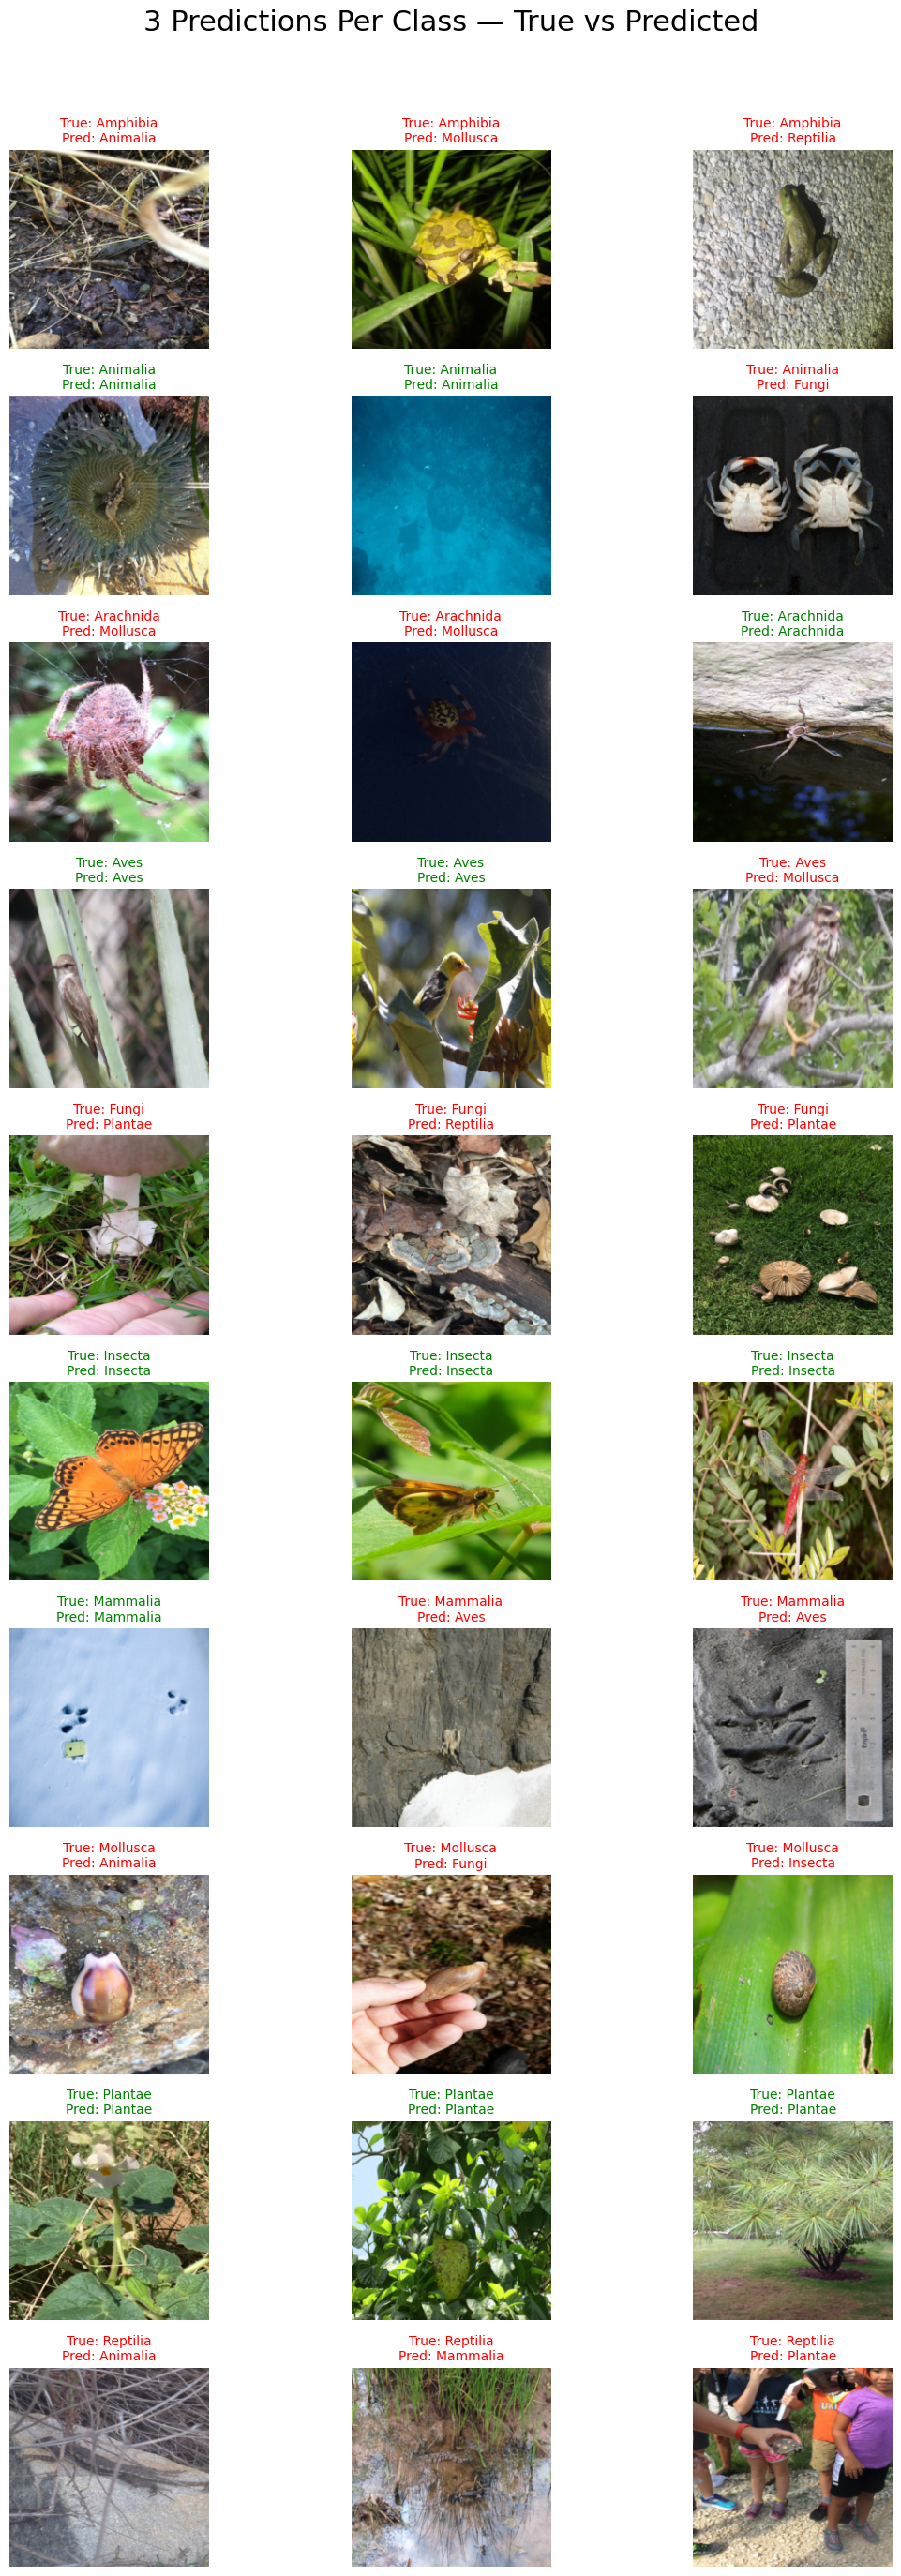

In [ ]:
import os
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import defaultdict
from PIL import Image
import random
from torch.amp import autocast

# Define the NeuralImageClassifier class that matches your training code
class NeuralImageClassifier(nn.Module):
    """Convolutional neural network for image classification."""

    def __init__(self, channel_sizes, activation_function, hidden_size,
                 dropout_prob, class_count, image_dimensions, use_normalization=False):
        super(NeuralImageClassifier, self).__init__()

        # Build convolutional feature extractor
        self.feature_extractor = self._build_feature_layers(
            channel_sizes, activation_function, use_normalization
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Calculate output dimensions from convolutional layers
        test_input = torch.zeros(1, 3, image_dimensions, image_dimensions)
        conv_output = self.feature_extractor(test_input)
        flattened_size = conv_output.view(1, -1).size(1)

        # Classification head
        self.classifier_head = nn.Sequential(
            nn.Linear(flattened_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, class_count)
        )

    def _build_feature_layers(self, channel_sizes, activation_function, use_normalization):
        """Create the feature extraction layers."""
        layers = []
        input_channels = 3  # RGB input

        for output_channels in channel_sizes:
            # Convolutional layer
            layers.append(nn.Conv2d(
                input_channels,
                output_channels,
                kernel_size=3,
                padding=1
            ))

            # Optional batch normalization
            if use_normalization:
                layers.append(nn.BatchNorm2d(output_channels))

            # Activation function
            layers.append(activation_function())

            # Pooling layer to reduce dimensions
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            # Update input channels for next layer
            input_channels = output_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass through the network."""
        features = self.feature_extractor(x)
        flattened = self.flatten_layer(features)
        output = self.classifier_head(flattened)
        return output

# Paths
data_dir = "/kaggle/input/nature/inaturalist_12K"
model_dir = "/kaggle/working/"

# Load config
with open(os.path.join(model_dir, "best_hyperparameters.json"), "r") as f:
    config = json.load(f)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform for test
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load test data
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Rebuild model
model = NeuralImageClassifier(
    channel_sizes=config["channel_architecture"],
    activation_function=getattr(nn, config["nonlinearity"]),
    hidden_size=config["hidden_layer_size"],
    dropout_prob=config["dropout_probability"],
    use_normalization=config["use_normalization"],
    class_count=10,  # Number of classes in dataset
    image_dimensions=224
).to(device)

# Load weights
model.load_state_dict(torch.load(os.path.join(model_dir, "best_model.pth"), map_location=device))
model.eval()

# Accuracy Calculation
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Use mixed precision for evaluation
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            outputs = model(images)

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

# --- Predict 3 samples per class ---
class_names = test_dataset.classes
class_to_indices = defaultdict(list)

# Group indices by class
for idx, (_, label) in enumerate(test_dataset):
    class_to_indices[label].append(idx)

# Select 3 random indices per class
selected_indices = []
for class_id in range(len(class_names)):
    selected_indices.extend(random.sample(class_to_indices[class_id], 3))

# Plot predictions
fig, axes = plt.subplots(10, 3, figsize=(12, 28))
fig.suptitle("3 Predictions Per Class — True vs Predicted", fontsize=22)

for ax, idx in zip(axes.flatten(), selected_indices):
    image, true_label = test_dataset[idx]

    input_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            pred = model(input_tensor).argmax(1).item()

    # Convert tensor to display-friendly format
    img_to_show = image.permute(1, 2, 0).cpu().numpy()

    ax.imshow(img_to_show)
    ax.axis("off")
    ax.set_title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred]}",
        fontsize=10,
        color="green" if pred == true_label else "red"
    )

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()